# Model Predicting the Winner after the First Inning without Binning

In [2]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, classification_report
pd.set_option('display.max_columns', None)

In [3]:
# Load data
rdata = pd.read_csv('./data/data.csv')
rdata.head()

,Unnamed: 0,id,series,start_datetime,timezone,ground,longitude,latitude,altitude,match_length_overs,match_length_balls,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,toss_winner,toss_choice,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2
0,1,6690,Big Bash League 2014/15,2015-01-28 08:40:00,Australia/Sydney,Manuka Oval,149.134592,-35.318131,555,20,120,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,Sydney Sixers,Bat,1.893,2.02,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5
1,2,6696,Big Bash League 2014/15,2014-12-18 08:40:00,Australia/Adelaide,Adelaide Oval,138.596111,-34.915556,19,20,120,120,120,Adelaide Strikers,Melbourne Stars,0,Melbourne Stars,Melbourne Stars,Bat,NaN,NaN,Adelaide Strikers,75,120,1,0,2,1,0,0,149,148,149.0,NaN,2,7,1,4
2,3,6700,Big Bash League 2014/15,2014-12-19 08:40:00,Australia/Sydney,Sydney Cricket Ground,151.224771,-33.891645,30,20,120,120,120,Sydney Sixers,Melbourne Renegades,0,Melbourne Renegades,Sydney Sixers,Bowl,NaN,NaN,Sydney Sixers,113,120,0,0,4,1,0,0,158,154,155.0,NaN,2,7,2,6
3,4,6702,Big Bash League 2014/15,2014-12-20 08:10:00,Australia/Melbourne,Melbourne Cricket Ground,144.983449,-37.819967,12,20,120,120,120,Melbourne Stars,Hobart Hurricanes,0,Hobart Hurricanes,Melbourne Stars,Bowl,NaN,NaN,Hobart Hurricanes,120,120,0,0,2,1,0,3,138,190,191.0,NaN,9,5,1,2
4,5,6705,Big Bash League 2014/15,2015-01-25 08:10:00,Australia/Perth,W.A.C.A. Ground,115.879576,-31.959793,7,20,120,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,Perth Scorchers,Bat,1.775,2.17,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4


# Data Exploring
**[Consideration]**
- Even if max_balls_teamX are the same for both teams, it is possible that the target for the second inning team is not Runs + 1. It could be related to the Wickets lost by the first inning team.
- When **Max_balls_teamX > Balls_teamX**: 1) Reached the Target, 2) Lost all Wickets, 3) The game was curtailed.

**Max_balls_teamX ≠ 120, but Max_balls_team1 = Max_balls_team2**

In [4]:
df = rdata.loc[rdata['max_balls_team1'] == rdata['max_balls_team2']]
len(df.loc[(df['max_balls_team1'] != 120) & (df['max_balls_team2'] != 120)])   # 14 instances

14

## Interrupted matches (less than 120 balls)

**(run_team1 + 1) ≠ (target_team2)** 

When max_ball was adjusted before the inning, target was also adjusted accordingly

In [5]:
# Team1 batted the first inning, and team2 has a target
df = rdata[rdata['target_team1'].isnull()]
cols = ['max_balls_team1', 'max_balls_team2', 'balls_team1', 'balls_team2', 'runs_team1', 'runs_team2', 'target_team1', 'target_team2', 'wickets_team1', 'wickets_team2']
df.loc[df['runs_team1']+1 != df['target_team2'], cols]

,max_balls_team1,max_balls_team2,balls_team1,balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2
16,120,102,102,82,77,84,NaN,82.0,7,5
52,120,114,120,49,167,58,NaN,162.0,5,3
73,120,30,79,26,109,51,NaN,51.0,4,1
321,108,66,66,45,69,55,NaN,80.0,5,3
349,84,84,84,84,143,125,NaN,147.0,4,5
363,120,84,120,84,172,122,NaN,135.0,4,7
390,120,72,102,72,166,117,NaN,111.0,6,2
399,102,60,60,60,115,111,NaN,129.0,3,5
464,108,108,108,102,133,137,NaN,135.0,9,4


**(run_team2 + 1) ≠ (target_team1)** 

In [6]:
# Team2 batted the first inning, and team1 has a target
df = rdata[rdata['target_team2'].isnull()]
cols = ['max_balls_team1', 'max_balls_team2', 'balls_team1', 'balls_team2', 'runs_team1', 'runs_team2', 'target_team1', 'target_team2', 'wickets_team1', 'wickets_team2']
df.loc[df['runs_team2']+1 != df['target_team1'], cols]

,max_balls_team1,max_balls_team2,balls_team1,balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2
118,30,120,30,120,48,193,54.0,NaN,6,5
166,78,120,78,108,142,183,139.0,NaN,2,2
213,102,102,101,102,153,149,151.0,NaN,4,4
286,48,120,48,120,74,181,90.0,NaN,6,5
297,72,120,63,120,85,128,84.0,NaN,1,6
329,30,48,30,48,60,119,77.0,NaN,4,4
345,96,96,33,95,28,76,75.0,NaN,2,10
358,72,120,70,90,97,99,96.0,NaN,3,4
377,36,120,7,102,10,158,76.0,NaN,1,6
406,84,120,76,120,132,166,129.0,NaN,5,6


**runs_team1 < runs_team2, but team1 won the game**

In [7]:
df = rdata.loc[rdata['runs_team1'] < rdata['runs_team2']]
df.loc[df['victor'] == df['team1']]   # 5 instances

,Unnamed: 0,id,series,start_datetime,timezone,ground,longitude,latitude,altitude,match_length_overs,match_length_balls,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,toss_winner,toss_choice,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2
166,167,10675,Big Bash League 2012/13,2013-01-16 11:00:00,Australia/Perth,W.A.C.A. Ground,115.879576,-31.959793,7,20,120,78,120,Perth Scorchers,Melbourne Stars,0,Melbourne Stars,Perth Scorchers,Bowl,1.637,2.420,Perth Scorchers,78,108,4,0,3,2,2,3,142,183,139.0,NaN,2,2,1,1
297,298,14378,KFC Big Bash League 2018/19,2019-02-02 08:00:00,Australia/Sydney,Sydney Cricket Ground,151.224771,-33.891645,30,20,120,72,120,Sydney Sixers,Sydney Thunder,0,Sydney Thunder,Sydney Sixers,Bowl,1.680,2.250,Sydney Sixers,63,120,0,1,0,3,0,0,85,128,84.0,NaN,1,6,1,2
345,346,15797,KFC Big Bash League 2019/20,2020-01-18 08:10:00,Australia/Sydney,Sydney Showground Stadium,151.067879,-33.843277,18,20,120,96,96,Sydney Thunder,Sydney Sixers,0,Sydney Sixers,Sydney Thunder,Bowl,1.833,2.030,Sydney Thunder,33,95,0,0,0,1,1,0,28,76,75.0,NaN,2,10,1,4
358,359,15810,KFC Big Bash League 2019/20,2020-01-26 03:45:00,Australia/Sydney,Sydney Showground Stadium,151.067879,-33.843277,18,20,120,72,120,Sydney Thunder,Perth Scorchers,0,Perth Scorchers,Perth Scorchers,Bat,2.310,1.654,Sydney Thunder,70,90,0,0,1,1,0,0,97,99,96.0,NaN,3,4,1,0
406,407,18452,KFC T20 Big Bash League 2020/21,2021-01-13 08:15:00,Australia/Sydney,Manuka Oval,149.134592,-35.318131,555,20,120,84,120,Sydney Sixers,Sydney Thunder,1,Sydney Thunder,Sydney Sixers,Bowl,2.140,1.752,Sydney Sixers,76,120,1,4,2,1,0,0,132,166,129.0,NaN,5,6,2,9


**runs_team1 > runs_team2, but team2 won the game**

In [8]:
df = rdata.loc[rdata['runs_team1'] > rdata['runs_team2']]
df.loc[df['victor'] == df['team2'], ['team1', 'team2', 'victor']]   # 4 instances

,team1,team2,victor
73,Brisbane Heat,Perth Scorchers,Perth Scorchers
92,Perth Scorchers,Melbourne Stars,Melbourne Stars
321,Hobart Hurricanes,Melbourne Stars,Melbourne Stars
390,Melbourne Renegades,Sydney Thunder,Sydney Thunder


## Curtailed matches (stopped without finishing the Max_balls_teamX)

**Curtailed games**

A team didn't lose 10 wickets and the target was not achieved, but the game was stopped (balls < max_balls_teamX)

In [9]:
# Team 1
df = rdata.loc[rdata['balls_team1'] < rdata['max_balls_team1']]
df2 = df.loc[df['wickets_team1'] != 10]
df3 = df2.loc[df2['runs_team1'] < df2['target_team1']]
df3     # 7 instances

,Unnamed: 0,id,series,start_datetime,timezone,ground,longitude,latitude,altitude,match_length_overs,match_length_balls,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,toss_winner,toss_choice,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2
49,50,8364,Big Bash League 2011/12,2012-01-08 07:00:00,Australia/Sydney,Stadium Australia,151.063413,-33.847116,14,20,120,96,96,Sydney Thunder,Sydney Sixers,0,Sydney Sixers,Sydney Sixers,Bat,2.010,1.952,Sydney Sixers,33,96,0,2,1,1,1,1,29,117,118.0,NaN,4,7,1,3
116,117,9557,Big Bash League 2013/14,2013-12-22 02:50:00,Australia/Hobart,Bellerive Oval,147.373739,-42.877361,10,20,120,48,48,Hobart Hurricanes,Adelaide Strikers,0,Adelaide Strikers,Hobart Hurricanes,Bowl,1.699,2.290,NaN,0,36,0,0,0,4,0,0,0,87,88.0,NaN,0,1,0,2
175,176,12157,Big Bash League 2016/17,2017-01-01 07:10:00,Australia/Melbourne,Melbourne Cricket Ground,144.983449,-37.819967,12,20,120,120,120,Melbourne Stars,Melbourne Renegades,0,Melbourne Renegades,Melbourne Stars,Bowl,1.625,2.440,Melbourne Renegades,108,120,0,1,0,3,3,0,151,171,172.0,NaN,9,4,6,3
270,271,14271,KFC Big Bash League 2018/19,2019-01-08 08:15:00,Australia/Sydney,Sydney Showground Stadium,151.067879,-33.843277,18,20,120,120,120,Sydney Thunder,Brisbane Heat,0,Brisbane Heat,Sydney Thunder,Bowl,1.694,2.230,Brisbane Heat,33,120,0,0,0,1,0,2,34,186,187.0,NaN,2,8,0,5
278,279,14332,KFC Big Bash League 2018/19,2019-01-17 08:15:00,Australia/Brisbane,Brisbane Cricket Ground,153.038085,-27.485838,11,20,120,120,120,Brisbane Heat,Sydney Thunder,0,Sydney Thunder,Sydney Thunder,Bat,1.602,2.410,NaN,18,120,0,0,1,4,0,3,10,186,187.0,NaN,2,4,1,3
345,346,15797,KFC Big Bash League 2019/20,2020-01-18 08:10:00,Australia/Sydney,Sydney Showground Stadium,151.067879,-33.843277,18,20,120,96,96,Sydney Thunder,Sydney Sixers,0,Sydney Sixers,Sydney Thunder,Bowl,1.833,2.030,Sydney Thunder,33,95,0,0,0,1,1,0,28,76,75.0,NaN,2,10,1,4
377,378,18394,KFC T20 Big Bash League 2020/21,2020-12-16 08:15:00,Australia/Hobart,York Park,147.138895,-41.425969,11,20,120,36,120,Melbourne Stars,Perth Scorchers,1,Perth Scorchers,Melbourne Stars,Bowl,1.714,2.190,NaN,7,102,0,0,0,5,0,0,10,158,76.0,NaN,1,6,0,6


In [10]:
# Team 2
df = rdata.loc[rdata['balls_team2'] < rdata['max_balls_team2']]
df2 = df.loc[df['wickets_team2'] != 10]
df3 = df2.loc[df2['runs_team2'] < df2['target_team2']]
df3     # 6 instances

,Unnamed: 0,id,series,start_datetime,timezone,ground,longitude,latitude,altitude,match_length_overs,match_length_balls,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,toss_winner,toss_choice,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2
31,32,6752,Big Bash League 2014/15,2015-01-12 08:40:00,Australia/Adelaide,Adelaide Oval,138.596111,-34.915556,19,20,120,60,60,Adelaide Strikers,Sydney Thunder,0,Adelaide Strikers,Sydney Thunder,Bowl,1.633,2.430,NaN,60,6,0,4,2,0,0,0,119,18,NaN,120.0,5,0,2,0
52,53,8367,Big Bash League 2011/12,2012-01-07 08:00:00,Australia/Melbourne,Melbourne Cricket Ground,144.983449,-37.819967,12,20,120,120,114,Melbourne Stars,Melbourne Renegades,0,Melbourne Stars,Melbourne Stars,Bat,2.090,1.885,Melbourne Stars,120,49,1,4,1,6,3,1,167,58,NaN,162.0,5,3,5,1
92,93,8759,Big Bash League 2012/13,2012-12-12 09:00:00,Australia/Perth,W.A.C.A. Ground,115.879576,-31.959793,7,20,120,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,Melbourne Stars,Bowl,2.680,1.535,Melbourne Stars,92,12,0,0,2,0,0,0,69,29,NaN,70.0,10,0,9,5
321,322,15773,KFC Big Bash League 2019/20,2019-12-30 08:10:00,Australia/Hobart,York Park,147.138895,-41.425969,11,20,120,108,66,Hobart Hurricanes,Melbourne Stars,1,Hobart Hurricanes,Melbourne Stars,Bowl,2.410,1.602,Melbourne Stars,66,45,2,0,1,0,0,0,69,55,NaN,80.0,5,3,2,6
342,343,15794,KFC Big Bash League 2019/20,2020-01-16 08:10:00,Australia/Sydney,Sydney Cricket Ground,151.224771,-33.891645,30,20,120,120,120,Sydney Sixers,Hobart Hurricanes,0,Sydney Sixers,Hobart Hurricanes,Bowl,1.893,1.962,NaN,40,0,0,0,1,0,0,0,45,0,NaN,46.0,2,0,0,0
362,363,16376,KFC Big Bash League 2019/20,2019-12-21 07:10:00,Australia/Sydney,Manuka Oval,149.134592,-35.318131,555,20,120,120,120,Adelaide Strikers,Sydney Thunder,1,Adelaide Strikers,Sydney Thunder,Bowl,2.050,1.820,NaN,120,26,0,0,0,0,0,0,161,40,NaN,162.0,5,1,3,2


**runs_team2 < target_team2, but team2 won the game**
- When the ultimate target was newly set as lower than the target_team2, team2 can win the game even though runs do not reach the target
- This is the subset of the curtailed games

In [11]:
df = rdata[rdata['runs_team2'] < rdata['target_team2']]
df.loc[df['team2'] == df['victor'], cols]

,max_balls_team1,max_balls_team2,balls_team1,balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2
92,120,120,92,12,69,29,NaN,70.0,10,0
321,108,66,66,45,69,55,NaN,80.0,5,3


**runs_team1 < target_team1, but team1 won the game**

In [12]:
df = rdata[rdata['runs_team1'] < rdata['target_team1']]
df.loc[df['team1'] == df['victor'], cols]

,max_balls_team1,max_balls_team2,balls_team1,balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2
345,96,96,33,95,28,76,75.0,NaN,2,10


# Preprocessing

## General preprocessing

In [13]:
# 1. Drop unnecessary columns
rdata = rdata.drop(['Unnamed: 0', 'id', 'series', 'timezone', 'ground', 'longitude', 'latitude', 'altitude', 'match_length_overs', 'match_length_balls', 'toss_choice'], axis=1)
rdata.head()

,start_datetime,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,toss_winner,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2
0,2015-01-28 08:40:00,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,Sydney Sixers,1.893,2.02,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5
1,2014-12-18 08:40:00,120,120,Adelaide Strikers,Melbourne Stars,0,Melbourne Stars,Melbourne Stars,NaN,NaN,Adelaide Strikers,75,120,1,0,2,1,0,0,149,148,149.0,NaN,2,7,1,4
2,2014-12-19 08:40:00,120,120,Sydney Sixers,Melbourne Renegades,0,Melbourne Renegades,Sydney Sixers,NaN,NaN,Sydney Sixers,113,120,0,0,4,1,0,0,158,154,155.0,NaN,2,7,2,6
3,2014-12-20 08:10:00,120,120,Melbourne Stars,Hobart Hurricanes,0,Hobart Hurricanes,Melbourne Stars,NaN,NaN,Hobart Hurricanes,120,120,0,0,2,1,0,3,138,190,191.0,NaN,9,5,1,2
4,2015-01-25 08:10:00,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,Perth Scorchers,1.775,2.17,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4


In [14]:
# 2. Add derby column
# The way how to choose the city from dataframe and inside apply function is different!
rdata['derby'] = rdata.apply(lambda x: 1 if x['team1'].split()[0] == x['team2'].split()[0] else 0, axis=1)
rdata.head()

,start_datetime,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,toss_winner,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2,derby
0,2015-01-28 08:40:00,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,Sydney Sixers,1.893,2.02,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5,0
1,2014-12-18 08:40:00,120,120,Adelaide Strikers,Melbourne Stars,0,Melbourne Stars,Melbourne Stars,NaN,NaN,Adelaide Strikers,75,120,1,0,2,1,0,0,149,148,149.0,NaN,2,7,1,4,0
2,2014-12-19 08:40:00,120,120,Sydney Sixers,Melbourne Renegades,0,Melbourne Renegades,Sydney Sixers,NaN,NaN,Sydney Sixers,113,120,0,0,4,1,0,0,158,154,155.0,NaN,2,7,2,6,0
3,2014-12-20 08:10:00,120,120,Melbourne Stars,Hobart Hurricanes,0,Hobart Hurricanes,Melbourne Stars,NaN,NaN,Hobart Hurricanes,120,120,0,0,2,1,0,3,138,190,191.0,NaN,9,5,1,2,0
4,2015-01-25 08:10:00,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,Perth Scorchers,1.775,2.17,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4,0


In [15]:
# 3. Extract month of start_datetime
rdata['start_month'] = rdata['start_datetime'].str.split('-').str[1]
rdata = rdata.drop('start_datetime', axis=1)
rdata.head()

,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,toss_winner,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2,derby,start_month
0,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,Sydney Sixers,1.893,2.02,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5,0,01
1,120,120,Adelaide Strikers,Melbourne Stars,0,Melbourne Stars,Melbourne Stars,NaN,NaN,Adelaide Strikers,75,120,1,0,2,1,0,0,149,148,149.0,NaN,2,7,1,4,0,12
2,120,120,Sydney Sixers,Melbourne Renegades,0,Melbourne Renegades,Sydney Sixers,NaN,NaN,Sydney Sixers,113,120,0,0,4,1,0,0,158,154,155.0,NaN,2,7,2,6,0,12
3,120,120,Melbourne Stars,Hobart Hurricanes,0,Hobart Hurricanes,Melbourne Stars,NaN,NaN,Hobart Hurricanes,120,120,0,0,2,1,0,3,138,190,191.0,NaN,9,5,1,2,0,12
4,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,Perth Scorchers,1.775,2.17,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4,0,01


In [16]:
# 4. Dummy variables for start_month
month = pd.get_dummies(rdata['start_month'], prefix='month', drop_first=True)   # k categories -> k-1 dummies
rdata = pd.concat([rdata, month], axis=1)

In [17]:
# 5. Add home_venue
home_venue = rdata['neutral_venue'].map({1:0, 0:1})
rdata.insert(6, 'home_venue', home_venue)
rdata.head()

,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,home_venue,toss_winner,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2,derby,start_month,month_02,month_12
0,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,0,Sydney Sixers,1.893,2.02,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5,0,01,0,0
1,120,120,Adelaide Strikers,Melbourne Stars,0,Melbourne Stars,1,Melbourne Stars,NaN,NaN,Adelaide Strikers,75,120,1,0,2,1,0,0,149,148,149.0,NaN,2,7,1,4,0,12,0,1
2,120,120,Sydney Sixers,Melbourne Renegades,0,Melbourne Renegades,1,Sydney Sixers,NaN,NaN,Sydney Sixers,113,120,0,0,4,1,0,0,158,154,155.0,NaN,2,7,2,6,0,12,0,1
3,120,120,Melbourne Stars,Hobart Hurricanes,0,Hobart Hurricanes,1,Melbourne Stars,NaN,NaN,Hobart Hurricanes,120,120,0,0,2,1,0,3,138,190,191.0,NaN,9,5,1,2,0,12,0,1
4,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,1,Perth Scorchers,1.775,2.17,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4,0,01,0,0


In [18]:
# 6. Drop rows if victor is NA
rdata['victor'].isnull().sum()      # 6 instances
rdata = rdata.dropna(subset=['victor'], axis=0)
rdata.head()

,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,home_venue,toss_winner,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2,derby,start_month,month_02,month_12
0,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,0,Sydney Sixers,1.893,2.02,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5,0,01,0,0
1,120,120,Adelaide Strikers,Melbourne Stars,0,Melbourne Stars,1,Melbourne Stars,NaN,NaN,Adelaide Strikers,75,120,1,0,2,1,0,0,149,148,149.0,NaN,2,7,1,4,0,12,0,1
2,120,120,Sydney Sixers,Melbourne Renegades,0,Melbourne Renegades,1,Sydney Sixers,NaN,NaN,Sydney Sixers,113,120,0,0,4,1,0,0,158,154,155.0,NaN,2,7,2,6,0,12,0,1
3,120,120,Melbourne Stars,Hobart Hurricanes,0,Hobart Hurricanes,1,Melbourne Stars,NaN,NaN,Hobart Hurricanes,120,120,0,0,2,1,0,3,138,190,191.0,NaN,9,5,1,2,0,12,0,1
4,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,1,Perth Scorchers,1.775,2.17,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4,0,01,0,0


In [19]:
# 7. Drop rows if victor is Tie
(rdata['victor'] == 'Tie').sum()      # 4 instances
rdata = rdata.drop(rdata[rdata['victor'] == 'Tie'].index, axis=0)
rdata.head()

,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,home_venue,toss_winner,dbMktPriceTeam1,dbMktPriceTeam2,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2,derby,start_month,month_02,month_12
0,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,0,Sydney Sixers,1.893,2.02,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5,0,01,0,0
1,120,120,Adelaide Strikers,Melbourne Stars,0,Melbourne Stars,1,Melbourne Stars,NaN,NaN,Adelaide Strikers,75,120,1,0,2,1,0,0,149,148,149.0,NaN,2,7,1,4,0,12,0,1
2,120,120,Sydney Sixers,Melbourne Renegades,0,Melbourne Renegades,1,Sydney Sixers,NaN,NaN,Sydney Sixers,113,120,0,0,4,1,0,0,158,154,155.0,NaN,2,7,2,6,0,12,0,1
3,120,120,Melbourne Stars,Hobart Hurricanes,0,Hobart Hurricanes,1,Melbourne Stars,NaN,NaN,Hobart Hurricanes,120,120,0,0,2,1,0,3,138,190,191.0,NaN,9,5,1,2,0,12,0,1
4,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,1,Perth Scorchers,1.775,2.17,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4,0,01,0,0


In [20]:
# 8. Drop rows if dbMktPrice is NaN
rdata['dbMktPriceTeam1'].isnull().sum()     # 9 instances
rdata['dbMktPriceTeam2'].isnull().sum()     # 9 instances
rdata = rdata.dropna(subset=['dbMktPriceTeam1', 'dbMktPriceTeam2'], axis=0)

# 9. Drop dbMktPrice columns
data = rdata.drop(['dbMktPriceTeam1','dbMktPriceTeam2'], axis=1)
data.head()

,max_balls_team1,max_balls_team2,team1,team2,neutral_venue,first_innings,home_venue,toss_winner,victor,balls_team1,balls_team2,byes_team1,byes_team2,leg_byes_team1,leg_byes_team2,no_balls_team1,no_balls_team2,runs_team1,runs_team2,target_team1,target_team2,wickets_team1,wickets_team2,wides_team1,wides_team2,derby,start_month,month_02,month_12
0,120,120,Perth Scorchers,Sydney Sixers,1,Sydney Sixers,0,Sydney Sixers,Perth Scorchers,120,120,0,0,2,3,2,0,148,147,148.0,NaN,6,5,1,5,0,01,0,0
4,120,120,Perth Scorchers,Melbourne Stars,0,Perth Scorchers,1,Perth Scorchers,Perth Scorchers,120,119,0,0,2,4,0,0,144,126,NaN,145.0,7,10,3,4,0,01,0,0
5,120,120,Adelaide Strikers,Hobart Hurricanes,0,Hobart Hurricanes,1,Hobart Hurricanes,Adelaide Strikers,87,120,0,1,3,2,0,0,141,136,137.0,NaN,2,8,1,2,0,12,0,1
6,120,120,Melbourne Renegades,Sydney Thunder,0,Sydney Thunder,1,Melbourne Renegades,Melbourne Renegades,83,120,0,0,2,0,0,1,118,114,115.0,NaN,2,6,2,4,0,12,0,1
7,120,120,Sydney Sixers,Perth Scorchers,0,Perth Scorchers,1,Perth Scorchers,Perth Scorchers,105,120,0,0,2,1,0,0,99,135,136.0,NaN,10,7,4,1,0,12,0,1


In [21]:
# Export the processed data
data.to_csv('./data/pjt03_data_processed.csv')

## Specific preprocessing
- Only need first inning team's records
- Change instances in the first inning team's point of view and predict if the team wins or not
- Runs_teamX includes extras, so consider redundancy

**For team1**

In [22]:
# Instances when the first inning team is team1
t1_col = ['team1', 'neutral_venue', 'home_venue', 'toss_winner', 'max_balls_team1', 'balls_team1', 'byes_team1', 'leg_byes_team1', 'no_balls_team1', 
          'wides_team1', 'runs_team1', 'wickets_team1', 'max_balls_team2', 'target_team2', 'derby', 'start_month', 'month_02', 'month_12', 'victor']
t1 = data.loc[data['team1'] == data['first_innings'], t1_col]
t1.tail()

,team1,neutral_venue,home_venue,toss_winner,max_balls_team1,balls_team1,byes_team1,leg_byes_team1,no_balls_team1,wides_team1,runs_team1,wickets_team1,max_balls_team2,target_team2,derby,start_month,month_02,month_12,victor
483,Melbourne Stars,0,1,Hobart Hurricanes,120,120,0,1,0,5,273,2,120,274.0,0,01,0,0,Melbourne Stars
485,Perth Scorchers,1,0,Perth Scorchers,120,120,0,3,0,3,189,3,120,190.0,0,01,0,0,Perth Scorchers
486,Adelaide Strikers,1,0,Adelaide Strikers,120,120,0,2,0,3,188,6,120,189.0,0,01,0,0,Adelaide Strikers
487,Adelaide Strikers,1,0,Adelaide Strikers,120,120,1,1,0,3,184,6,120,185.0,0,01,0,0,Adelaide Strikers
489,Perth Scorchers,1,0,Sydney Sixers,120,120,0,1,0,4,171,6,120,172.0,0,01,0,0,Perth Scorchers


In [23]:
# Convert to binary for toss_winner and victor
t1['toss_winner'] = t1.apply(lambda x: 1 if x['team1'] == x['toss_winner'] else 0, axis=1)
t1['victor'] = t1.apply(lambda x: 1 if x['team1'] == x['victor'] else 0, axis=1)
t1.tail()

,team1,neutral_venue,home_venue,toss_winner,max_balls_team1,balls_team1,byes_team1,leg_byes_team1,no_balls_team1,wides_team1,runs_team1,wickets_team1,max_balls_team2,target_team2,derby,start_month,month_02,month_12,victor
483,Melbourne Stars,0,1,0,120,120,0,1,0,5,273,2,120,274.0,0,01,0,0,1
485,Perth Scorchers,1,0,1,120,120,0,3,0,3,189,3,120,190.0,0,01,0,0,1
486,Adelaide Strikers,1,0,1,120,120,0,2,0,3,188,6,120,189.0,0,01,0,0,1
487,Adelaide Strikers,1,0,1,120,120,1,1,0,3,184,6,120,185.0,0,01,0,0,1
489,Perth Scorchers,1,0,0,120,120,0,1,0,4,171,6,120,172.0,0,01,0,0,1


In [24]:
# Rename columns
t1 = t1.rename(columns={'team1':'team', 'max_balls_team1':'max_balls_first', 'balls_team1':'balls', 'byes_team1':'byes', 'leg_byes_team1':'leg_byes', 
                        'no_balls_team1':'no_balls', 'wides_team1':'wides', 'runs_team1':'runs', 'wickets_team1':'wickets', 'max_balls_team2':'max_balls_second', 'target_team2':'target'})
t1.tail()

,team,neutral_venue,home_venue,toss_winner,max_balls_first,balls,byes,leg_byes,no_balls,wides,runs,wickets,max_balls_second,target,derby,start_month,month_02,month_12,victor
483,Melbourne Stars,0,1,0,120,120,0,1,0,5,273,2,120,274.0,0,01,0,0,1
485,Perth Scorchers,1,0,1,120,120,0,3,0,3,189,3,120,190.0,0,01,0,0,1
486,Adelaide Strikers,1,0,1,120,120,0,2,0,3,188,6,120,189.0,0,01,0,0,1
487,Adelaide Strikers,1,0,1,120,120,1,1,0,3,184,6,120,185.0,0,01,0,0,1
489,Perth Scorchers,1,0,0,120,120,0,1,0,4,171,6,120,172.0,0,01,0,0,1


**For team2**

In [25]:
# Instances when the first inning team is team2
t2_col = ['team2', 'neutral_venue', 'home_venue', 'toss_winner', 'max_balls_team2', 'balls_team2', 'byes_team2', 'leg_byes_team2', 'no_balls_team2', 
          'wides_team2', 'runs_team2', 'wickets_team2', 'max_balls_team1', 'target_team1', 'derby', 'start_month', 'month_02', 'month_12', 'victor']
t2 = data.loc[data['team2'] == data['first_innings'], t2_col]

# For team2, home_venue is always 0
t2['home_venue'] = 0
t2.head()

,team2,neutral_venue,home_venue,toss_winner,max_balls_team2,balls_team2,byes_team2,leg_byes_team2,no_balls_team2,wides_team2,runs_team2,wickets_team2,max_balls_team1,target_team1,derby,start_month,month_02,month_12,victor
0,Sydney Sixers,1,0,Sydney Sixers,120,120,0,3,0,5,147,5,120,148.0,0,01,0,0,Perth Scorchers
5,Hobart Hurricanes,0,0,Hobart Hurricanes,120,120,1,2,0,2,136,8,120,137.0,0,12,0,1,Adelaide Strikers
6,Sydney Thunder,0,0,Melbourne Renegades,120,120,0,0,1,4,114,6,120,115.0,0,12,0,1,Melbourne Renegades
7,Perth Scorchers,0,0,Perth Scorchers,120,120,0,1,0,1,135,7,120,136.0,0,12,0,1,Perth Scorchers
9,Perth Scorchers,0,0,Perth Scorchers,120,120,4,1,0,1,141,8,120,142.0,0,01,0,0,Perth Scorchers


In [26]:
# Convert to binary for toss_winner and victor
t2['toss_winner'] = t2.apply(lambda x: 1 if x['team2'] == x['toss_winner'] else 0, axis=1)
t2['victor'] = t2.apply(lambda x: 1 if x['team2'] == x['victor'] else 0, axis=1)
t2.head()

,team2,neutral_venue,home_venue,toss_winner,max_balls_team2,balls_team2,byes_team2,leg_byes_team2,no_balls_team2,wides_team2,runs_team2,wickets_team2,max_balls_team1,target_team1,derby,start_month,month_02,month_12,victor
0,Sydney Sixers,1,0,1,120,120,0,3,0,5,147,5,120,148.0,0,01,0,0,0
5,Hobart Hurricanes,0,0,1,120,120,1,2,0,2,136,8,120,137.0,0,12,0,1,0
6,Sydney Thunder,0,0,0,120,120,0,0,1,4,114,6,120,115.0,0,12,0,1,0
7,Perth Scorchers,0,0,1,120,120,0,1,0,1,135,7,120,136.0,0,12,0,1,1
9,Perth Scorchers,0,0,1,120,120,4,1,0,1,141,8,120,142.0,0,01,0,0,1


In [27]:
# Rename columns
t2 = t2.rename(columns={'team2':'team', 'max_balls_team2': 'max_balls_first', 'balls_team2':'balls', 'byes_team2':'byes', 'leg_byes_team2':'leg_byes', 
                        'no_balls_team2':'no_balls', 'wides_team2':'wides', 'runs_team2':'runs', 'wickets_team2':'wickets', 'max_balls_team1':'max_balls_second', 'target_team1':'target'})
t2.head()

,team,neutral_venue,home_venue,toss_winner,max_balls_first,balls,byes,leg_byes,no_balls,wides,runs,wickets,max_balls_second,target,derby,start_month,month_02,month_12,victor
0,Sydney Sixers,1,0,1,120,120,0,3,0,5,147,5,120,148.0,0,01,0,0,0
5,Hobart Hurricanes,0,0,1,120,120,1,2,0,2,136,8,120,137.0,0,12,0,1,0
6,Sydney Thunder,0,0,0,120,120,0,0,1,4,114,6,120,115.0,0,12,0,1,0
7,Perth Scorchers,0,0,1,120,120,0,1,0,1,135,7,120,136.0,0,12,0,1,1
9,Perth Scorchers,0,0,1,120,120,4,1,0,1,141,8,120,142.0,0,01,0,0,1


**Combine team1 and team2**

In [28]:
data2 = pd.concat([t1, t2], axis=0)
data2.head()

,team,neutral_venue,home_venue,toss_winner,max_balls_first,balls,byes,leg_byes,no_balls,wides,runs,wickets,max_balls_second,target,derby,start_month,month_02,month_12,victor
4,Perth Scorchers,0,1,1,120,120,0,2,0,3,144,7,120,145.0,0,01,0,0,1
8,Brisbane Heat,0,1,0,120,120,2,0,1,2,164,8,120,165.0,0,12,0,1,1
12,Sydney Thunder,0,1,0,120,120,2,2,0,1,106,8,120,107.0,0,01,0,0,0
13,Brisbane Heat,0,1,0,120,120,0,0,0,3,198,6,120,199.0,0,01,0,0,1
16,Sydney Thunder,0,1,0,120,102,0,0,0,3,77,7,102,82.0,0,01,0,0,0


In [29]:
# Save it as pickle to save the dtypes
# data2.to_pickle('./data/pjt03_specific_data.pkl')

**Train/Test split**

In [30]:
X = data2[['neutral_venue', 'home_venue', 'toss_winner', 'max_balls_first', 'balls', 'byes', 'leg_byes', 'no_balls', 'wides', 'runs', 'wickets', 'max_balls_second', 'target', 'derby', 'month_02', 'month_12']]
y = data2['victor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_test.shape

((376, 16), (95,))

**Normalization**

In [31]:
ct = make_column_transformer((StandardScaler(), ['max_balls_first', 'balls', 'byes', 'leg_byes', 'no_balls', 'wides', 'runs', 'wickets', 'max_balls_second', 'target']), remainder='passthrough')
X_train_sc = ct.fit_transform(X_train)
X_test_sc = ct.transform(X_test)

# Benchmark

In [32]:
# Null F1 score: predict the class of majority
data2['victor'].value_counts()          # Accuracy: 50.74

1    239
0    232
Name: victor, dtype: int64

In [33]:
# F1-score
y_pred = np.array([1]*471)
f1_score(data2['victor'], y_pred)    # 67.32

0.6732394366197183

# Exploratory Data Analysis
One feature is not much predictive -> move on to feature selection

In [34]:
# Neutral venue: no discrimination
n_v = pd.crosstab(index=data2['neutral_venue'], columns=data2['victor'])
# dfi.export(n_v, './figure/neutral_venue.png')
n_v

victor,0,1
neutral_venue,,
0,200,203
1,32,36


In [35]:
# Home venue: no discrimination
h_v = pd.crosstab(index=data2['home_venue'], columns=data2['victor'])
# dfi.export(h_v, './figure/home_venue.png')
h_v

victor,0,1
home_venue,,
0,140,142
1,92,97


In [36]:
# Toss winner: no discrimination
t_w = pd.crosstab(index=data2['toss_winner'], columns=data2['victor'])
# dfi.export(t_w, './figure/toss_winner.png')
t_w

victor,0,1
toss_winner,,
0,135,127
1,97,112


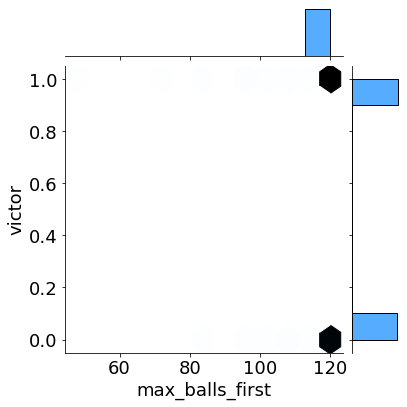

In [48]:
# Max_balls_first: no discrimination
plt.rc('font', size=18)
sns.jointplot(x=data2['max_balls_first'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

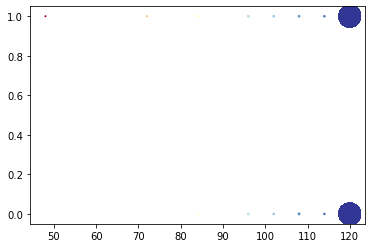

In [38]:
# Scatter plot
vc = data2['max_balls_first'].value_counts()
s = data2.apply(lambda x: vc[x['max_balls_first']], axis=1)
plt.scatter(x=data2['max_balls_first'], y=data2['victor'], s=s, c=data2['max_balls_first'], cmap='RdYlBu')

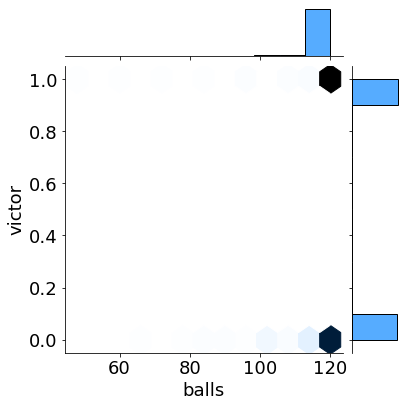

In [49]:
# Balls: no discrimination
plt.rc('font', size=18)
sns.jointplot(x=data2['balls'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

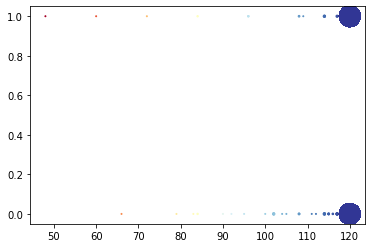

In [40]:
# Scatter plot
vc = data2['balls'].value_counts()
s = data2.apply(lambda x: vc[x['balls']], axis=1)
plt.scatter(x=data2['balls'], y=data2['victor'], s=s, c=data2['balls'], cmap='RdYlBu')

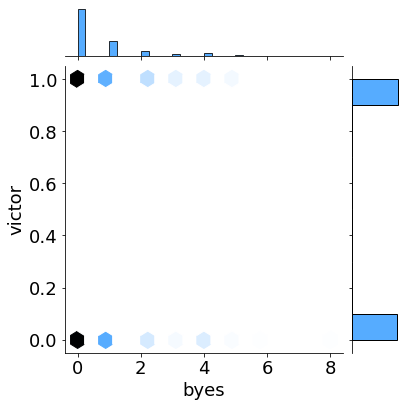

In [41]:
# Byes
plt.rc('font', size=18)
sns.jointplot(x=data2['byes'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

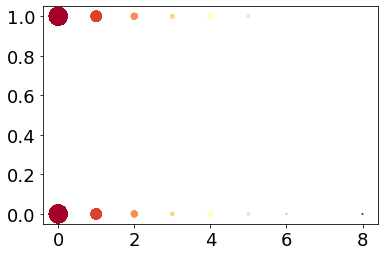

In [42]:
# Scatter plot
vc = data2['byes'].value_counts()
s = data2.apply(lambda x: vc[x['byes']], axis=1)
plt.scatter(x=data2['byes'], y=data2['victor'], s=s, c=data2['byes'], cmap='RdYlBu')

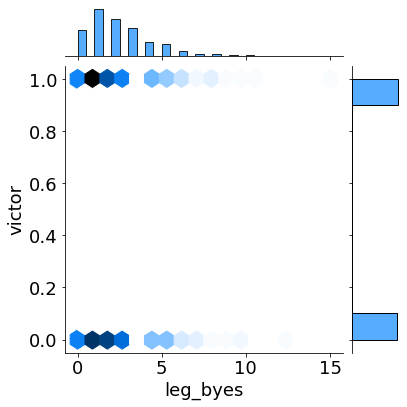

In [43]:
# Leg_byes
plt.rc('font', size=18)
sns.jointplot(x=data2['leg_byes'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

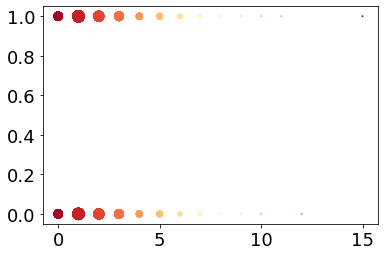

In [44]:
# Scatter plot
vc = data2['leg_byes'].value_counts()
s = data2.apply(lambda x: vc[x['leg_byes']], axis=1)
plt.scatter(x=data2['leg_byes'], y=data2['victor'], s=s, c=data2['leg_byes'], cmap='RdYlBu')

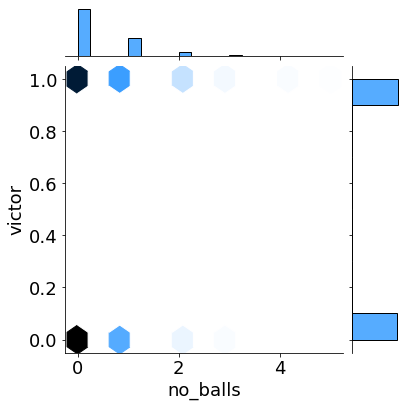

In [45]:
# No_balls
plt.rc('font', size=18)
sns.jointplot(x=data2['no_balls'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

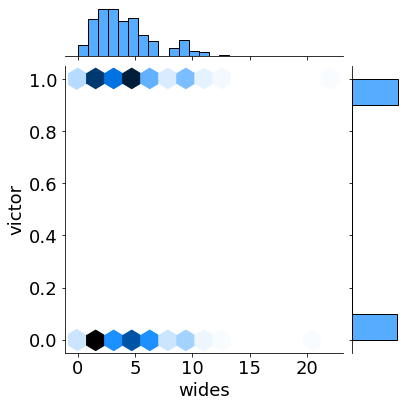

In [46]:
# Wides
plt.rc('font', size=18)
sns.jointplot(x=data2['wides'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

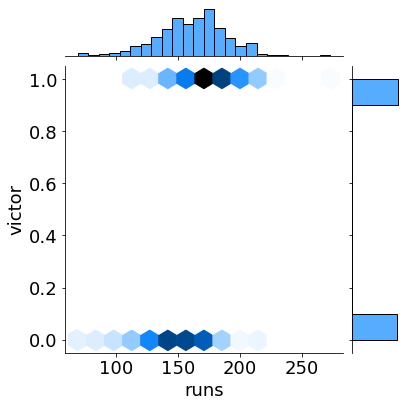

In [47]:
# Runs: a bit of discrimination
sns.jointplot(x=data2['runs'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

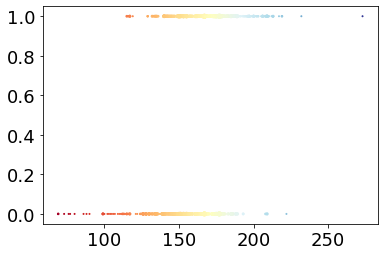

In [48]:
# Scatter plot
vc = data2['runs'].value_counts()
s = data2.apply(lambda x: vc[x['runs']], axis=1)
plt.scatter(x=data2['runs'], y=data2['victor'], s=s, c=data2['runs'], cmap='RdYlBu')

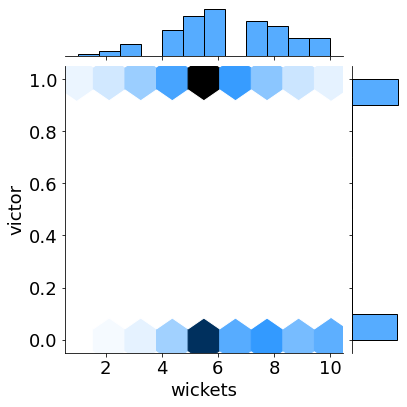

In [49]:
# Wickets: a bit of discrimination
plt.rc('font', size=18)
sns.jointplot(x=data2['wickets'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

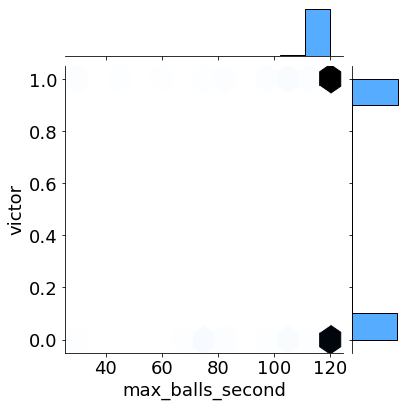

In [51]:
# Max_balls_second
sns.jointplot(x=data2['max_balls_second'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

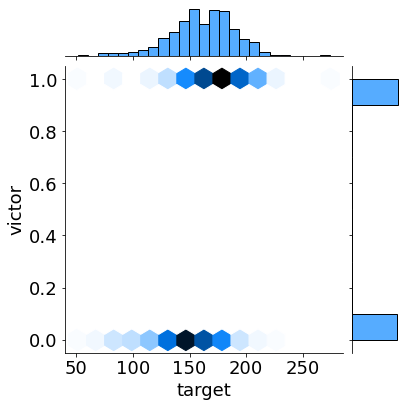

In [51]:
# Targets: a bit of discrimination
sns.jointplot(x=data2['target'], y=data2['victor'], kind='hex', color='dodgerblue')
plt.show()

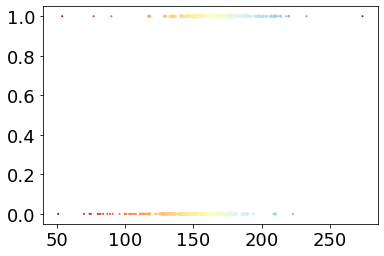

In [52]:
# Scatter plot
vc = data2['target'].value_counts()
s = data2.apply(lambda x: vc[x['target']], axis=1)
plt.scatter(x=data2['target'], y=data2['victor'], s=s, c=data2['target'], cmap='RdYlBu')

In [37]:
# Derby
derby = pd.crosstab(index=data2['derby'], columns=data2['victor'])
# dfi.export(derby, './figure/derby.png')
derby

victor,0,1
derby,,
0,205,224
1,27,15


In [38]:
# Month_02
m_02 = pd.crosstab(index=data2['month_02'], columns=data2['victor'])
# dfi.export(m_02, './figure/month_02.png')
m_02

victor,0,1
month_02,,
0,223,225
1,9,14


In [39]:
# month_12
m_12 = pd.crosstab(index=data2['month_12'], columns=data2['victor'])
# dfi.export(m_12, './figure/month_12.png')
m_12

victor,0,1
month_12,,
0,156,155
1,76,84


In [43]:
# Correlation coefficient
correlation = data2[['max_balls_first', 'balls', 'byes', 'leg_byes', 'no_balls', 'wides', 'runs', 'wickets', 'max_balls_second', 'target']].corr()
correlation = round(correlation, 4)
display(correlation)
# dfi.export(correlation, './figure/correlation.png', max_cols=-1, max_rows=-1)

,max_balls_first,balls,byes,leg_byes,no_balls,wides,runs,wickets,max_balls_second,target
max_balls_first,1.0000,0.7664,0.0305,0.0548,-0.0034,0.0484,0.1805,0.0911,0.5689,0.2025
balls,0.7664,1.0000,0.0545,0.0851,0.0103,0.0748,0.3803,0.0133,0.7027,0.4091
byes,0.0305,0.0545,1.0000,0.0233,-0.0584,0.0611,0.0144,-0.0270,-0.0006,0.0023
leg_byes,0.0548,0.0851,0.0233,1.0000,-0.0140,0.0793,0.0656,-0.0742,0.0389,0.0561
no_balls,-0.0034,0.0103,-0.0584,-0.0140,1.0000,0.0496,0.2115,-0.1249,-0.0076,0.1977
wides,0.0484,0.0748,0.0611,0.0793,0.0496,1.0000,0.1169,0.0366,0.0558,0.1085
runs,0.1805,0.3803,0.0144,0.0656,0.2115,0.1169,1.0000,-0.5523,0.1603,0.9445
wickets,0.0911,0.0133,-0.0270,-0.0742,-0.1249,0.0366,-0.5523,1.0000,0.1569,-0.4993
max_balls_second,0.5689,0.7027,-0.0006,0.0389,-0.0076,0.0558,0.1603,0.1569,1.0000,0.3953
target,0.2025,0.4091,0.0023,0.0561,0.1977,0.1085,0.9445,-0.4993,0.3953,1.0000


# Classification Analysis

## Logistic Regression
Solver='lbfgs' (default) and 'liblinear' produced the same results for feature selection but can produce a tiny bit different result for testing.

### Permutation importance

In [73]:
logr = LogisticRegression(solver='liblinear').fit(X_train_sc, y_train)
result = permutation_importance(logr, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])   

6 leg_byes 0.10786144716714438
9 runs 0.08552413312225086
8 wides 0.012823381747326845
0 neutral_venue 0.010133998621848116


In [54]:
# Use feature 1, 7, 9, 10
X_17910 = X.iloc[:, [0, 6, 8, 9]]

# Cross validation with pipeline
ct = make_column_transformer((StandardScaler(), ['leg_byes', 'wides', 'runs']), remainder='passthrough')
pl = make_pipeline(ct, LogisticRegression(solver='liblinear'))
cross_validate(pl, X_17910, y, cv=10, scoring='f1')['test_score'].mean()

0.7284029527822056

### Select from model

In [103]:
logr = LogisticRegression(solver='liblinear')
selector = SelectFromModel(logr).fit(X_train_sc, y_train)

for i in range(len(selector.get_support())):
    if selector.get_support()[i]:
        print(i, X.columns[i])

0 neutral_venue
6 leg_byes
8 wides
9 runs
12 target
13 derby
15 month_12


In [101]:
# Use feature 1, 7, 9, 10, 13, 14
X_179101314 = X.iloc[:, [0, 6, 8, 9, 12, 13]]
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'wides', 'runs', 'target']), remainder='passthrough')
pl = make_pipeline(sc, logr)
cross_validate(pl, X_179101314, y, cv=10, scoring='f1')['test_score'].mean()

0.7198509173234295

In [102]:
# Use feature 1, 7, 9, 10, 13, 14, 15, 16
X_1791013141516 = X.iloc[:, [0, 6, 8, 9, 12, 13, 14, 15]]
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'wides', 'runs', 'target']), remainder='passthrough')
pl = make_pipeline(sc, logr)
cross_validate(pl, X_1791013141516, y, cv=10, scoring='f1')['test_score'].mean()

0.7185631072445842

In [71]:
# Use all features
pl = make_pipeline(ct,  logr)
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.7226357804340846

## SVM

### Permutation importance

In [79]:
# 1. Default kernel (rbf) 
svc = SVC().fit(X_train_sc, y_train)
result = permutation_importance(svc, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])  

6 leg_byes 0.09507143357061518
9 runs 0.07708538354005084
5 byes 0.026502326304285152
4 balls 0.021189766683276212
3 max_balls_first 0.020303364019328918
7 no_balls 0.012890195597763877
0 neutral_venue 0.012230554482185917
8 wides 0.010568509793652004
11 max_balls_second 0.006069941706812643


In [78]:
# Use feature 1, 4, 5, 6, 7, 8, 9, 10, 12
X_ex_231113141516= X.iloc[:, [0, 3, 4, 5, 6, 7, 8, 9, 11]]
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'runs', 'byes', 'balls', 'max_balls_first', 'no_balls', 'wides', 'max_balls_second'])
                            , remainder='passthrough')
pl = make_pipeline(sc, SVC())
cross_validate(pl, X_ex_231113141516, y, cv=10, scoring='f1')['test_score'].mean()

0.7036765234160756

In [80]:
# 2. Linear kernel
svc = SVC(kernel='linear').fit(X_train_sc, y_train)
result = permutation_importance(svc, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])  

6 leg_byes 0.09970883418513757
9 runs 0.09795653413446387
8 wides 0.016642309674274814
0 neutral_venue 0.009510159157378673


In [81]:
# Use feature 1, 7, 9, 10
ct = make_column_transformer((StandardScaler(), ['leg_byes', 'wides', 'runs']), remainder='passthrough')
pl = make_pipeline(ct, SVC(kernel='linear'))
cross_validate(pl, X_17910, y, cv=10, scoring='f1')['test_score'].mean()

0.7179185746395279

### Select from model

In [90]:
svc = SVC(kernel='linear')
selector = SelectFromModel(svc).fit(X_train_sc, y_train)

for i in range(len(selector.get_support())):
    if selector.get_support()[i]:
        print(i, X.columns[i])

0 neutral_venue
6 leg_byes
8 wides
9 runs
12 target
13 derby


In [85]:
# Use feature 1, 7, 9, 10, 13, 14
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'wides', 'runs', 'target']), remainder='passthrough')
pl = make_pipeline(sc, svc)
cross_validate(pl, X_179101314, y, cv=10, scoring='f1')['test_score'].mean()

0.7047429064350876

In [91]:
# Use all feature with rbf kernel
pl = make_pipeline(ct, SVC(kernel='rbf'))
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.732000726340198

In [92]:
# Use all feature with linear kernel
pl = make_pipeline(ct, SVC(kernel='linear'))
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.7159041110347091

## Decision Tree

### Permutation importance

In [96]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, random_state=0).fit(X_train_sc, y_train)
result = permutation_importance(dt, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])  

6 leg_byes 0.2973411364772897
9 runs 0.06363947383435309
5 byes 0.052864161624936415
2 toss_winner 0.025696550625221904
1 home_venue 0.01281346430352075


In [114]:
# Use feature 2, 3, 6, 7, 10
X_236710 = X.iloc[:, [1, 2, 5, 6, 9]]
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'runs', 'byes']), remainder='passthrough')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, random_state=0)
pl = make_pipeline(sc, dt)
cross_validate(pl, X_236710, y, cv=10, scoring='f1')['test_score'].mean()

0.69801000573397

### Select from model

In [115]:
selector = SelectFromModel(dt).fit(X_train_sc, y_train)

for i in range(len(selector.get_support())):
    if selector.get_support()[i]:
        print(i, X.columns[i])

5 byes
6 leg_byes
9 runs


In [116]:
# Use feature 6, 7, 10
X_6710 = X.iloc[:, [5, 6, 9]]
pl = make_pipeline(StandardScaler(), dt)
cross_validate(pl, X_6710, y, cv=10, scoring='f1')['test_score'].mean()

0.6991042855335452

In [117]:
# Use all features
pl = make_pipeline(ct, dt)
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.7061575776845148

## AdaBoost

### Permutation importance

In [118]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train_sc, y_train)
result = permutation_importance(ada, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])  

6 leg_byes 0.20366442348313493
9 runs 0.1432659327541112
8 wides 0.014871711145727495


In [121]:
# Use feature 7, 9, 10
X_7910 = X.iloc[:, [6, 8, 9]]
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
pl = make_pipeline(StandardScaler(), ada)
cross_validate(pl, X_7910, y, cv=10, scoring='f1')['test_score'].mean()

0.6794464803202113

### Select from model

In [122]:
selector = SelectFromModel(ada).fit(X_train_sc, y_train)

for i in range(len(selector.get_support())):
    if selector.get_support()[i]:
        print(i, X.columns[i])

2 toss_winner
5 byes
6 leg_byes
9 runs


In [124]:
# Use feature 3, 6, 7, 10
X_36710 = X.iloc[:, [2, 5, 6, 9]]
sc = make_column_transformer((StandardScaler(), ['byes', 'leg_byes', 'runs']), remainder='passthrough')
pl = make_pipeline(sc, ada)
cross_validate(pl, X_36710, y, cv=10, scoring='f1')['test_score'].mean()

0.7076667061560402

In [126]:
# Use all features
pl = make_pipeline(ct, ada)
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.682293765991245

## Random Forest

### Permutation importance
Gini showed tiny bit better results but basically Entropy and Gini doesn't make big difference in test results.

**Entropy**

In [135]:
rf = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, random_state=0, max_samples=200).fit(X_train_sc, y_train)
result = permutation_importance(rf, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])     

6 leg_byes 0.08403322660575681
9 runs 0.04118465689212193
5 byes 0.013269096181177087
2 toss_winner 0.011630991778985767
4 balls 0.0055053706116968025


In [129]:
# Use feature 3, 5, 6, 7, 10
X_356710 = X.iloc[:, [2, 4, 5, 6, 9]]
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'runs', 'byes', 'balls']))
rf = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, random_state=0, max_samples=200)
pl = make_pipeline(sc, rf)
cross_validate(pl, X_356710, y, cv=10, scoring='f1')['test_score'].mean()

0.7249091415830546

**Gini impurity**

In [136]:
rf = RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, random_state=0, max_samples=200).fit(X_train_sc, y_train)
result = permutation_importance(rf, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])     

6 leg_byes 0.08869648747464065
9 runs 0.05773291564864429
5 byes 0.012431008170022096
2 toss_winner 0.008023262086234306
4 balls 0.006354185574758186
7 no_balls 0.0060673914403980515
8 wides 0.0037295832417783893


In [137]:
# Use feature 3, 5, 6, 7, 8, 9, 10
X_35678910 = X.iloc[:, [2, 4, 5, 6, 7, 8, 9]]
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'runs', 'byes', 'balls', 'no_balls', 'wides']))
rf = RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, random_state=0, max_samples=200)
pl = make_pipeline(sc, rf)
cross_validate(pl, X_35678910, y, cv=10, scoring='f1')['test_score'].mean()

0.7328847082469008

### Select from model
Entropy and Gini selected the same features, but Gini produced negligibly better results.

In [144]:
rf = RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, random_state=0, max_samples=200)
selector = SelectFromModel(rf).fit(X_train_sc, y_train)

for i in range(len(selector.get_support())):
    if selector.get_support()[i]:
        print(i, X.columns[i])

5 byes
6 leg_byes
7 no_balls
9 runs


In [145]:
# Use feature 6, 7, 8, 10
X_67810 = X.iloc[:, [5, 6, 7, 9]]
pl = make_pipeline(StandardScaler(), rf)
cross_validate(pl, X_67810, y, cv=10, scoring='f1')['test_score'].mean()

0.7170665011519229

In [146]:
# Use all features
pl = make_pipeline(ct, rf)
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.7286026315366179

## XGBoost

### Permutation importance

In [147]:
xgc = xgb.XGBClassifier(booster='gbtree', max_depth=5, min_child_weight=5, subsample=0.5, objective='binary:logistic', 
                        eval_metric='error', random_state=0, use_label_encoder=False)
xgc.fit(X_train_sc, y_train)
result = permutation_importance(xgc, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i])     

6 leg_byes 0.2778683870536721
9 runs 0.0607731477201335
5 byes 0.05719267975217479
7 no_balls 0.029404876492368524
2 toss_winner 0.02098677783059464
15 month_12 0.016111723369323084
3 max_balls_first 0.014752338674358245


In [150]:
# Use feature 3, 4, 6, 7, 8, 10
X_3467810 = X.iloc[:, [2, 3, 5, 6, 7, 9]]
sc = make_column_transformer((StandardScaler(), ['leg_byes', 'runs', 'byes', 'no_balls', 'max_balls_first']))
xgc = xgb.XGBClassifier(booster='gbtree', max_depth=5, min_child_weight=5, subsample=0.5, objective='binary:logistic', 
                        eval_metric='error', random_state=0, use_label_encoder=False)
pl = make_pipeline(sc, xgc)
cross_validate(pl, X_3467810, y, cv=10, scoring='f1')['test_score'].mean()

0.6493669112833669

In [151]:
# Use feature 3, 4, 6, 7, 8, 10, 15, 16
X_34678101516 = X.iloc[:, [2, 3, 5, 6, 7, 9, 14, 15]]
pl = make_pipeline(sc, xgc)
cross_validate(pl, X_34678101516, y, cv=10, scoring='f1')['test_score'].mean()

0.6493669112833669

### Select from model

In [152]:
selector = SelectFromModel(xgc).fit(X_train_sc, y_train)

for i in range(len(selector.get_support())):
    if selector.get_support()[i]:
        print(i, X.columns[i])

2 toss_winner
3 max_balls_first
4 balls
5 byes
6 leg_byes
7 no_balls
9 runs
11 max_balls_second
12 target
15 month_12


In [153]:
# Use all features except 1, 2, 9, 11, 14, 15, 16
X_ex_12911141516 = X.iloc[:, [2, 3, 4, 5, 6, 7, 9, 11, 12]]
sc = make_column_transformer((StandardScaler(), ['max_balls_first', 'balls', 'byes', 'leg_byes', 'no_balls', 'runs', 
                                                 'max_balls_second', 'target']), remainder='passthrough')
pl = make_pipeline(sc, xgc)
cross_validate(pl, X_ex_12911141516, y, cv=10, scoring='f1')['test_score'].mean()

0.6656748304942242

In [154]:
# Use all features except 1, 2, 9, 11, 14
X_ex_1291114 = X.iloc[:, [2, 3, 4, 5, 6, 7, 9, 11, 12, 14, 15]]
sc = make_column_transformer((StandardScaler(), ['max_balls_first', 'balls', 'byes', 'leg_byes', 'no_balls', 'runs', 
                                                 'max_balls_second', 'target']), remainder='passthrough')
pl = make_pipeline(sc, xgc)
cross_validate(pl, X_ex_1291114, y, cv=10, scoring='f1')['test_score'].mean()

0.6276723154893389

In [155]:
# Use all features
pl = make_pipeline(ct, xgc)
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.6404490564764714

## KNN
SelectFromModel is not suitable as it doesn't have coef_ or feature_importances_ attribute.

### Permutation importance

**Weight = 'distance'**

In [162]:
knn = KNeighborsClassifier(weights='distance').fit(X_train_sc, y_train)
result = permutation_importance(knn, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i]) 

6 leg_byes 0.19326821264536603
5 byes 0.1860243325552268
9 runs 0.18016055898429895
7 no_balls 0.16856999126389444
3 max_balls_first 0.16228445938111682
4 balls 0.13815687088431364
2 toss_winner 0.129438706106307
12 target 0.10612880996889813
11 max_balls_second 0.10543290421068141
15 month_12 0.09728420438914885
10 wickets 0.05379571464128098
13 derby 0.03075041082901243
1 home_venue 0.026221519906340873
8 wides 0.025174582673788738
14 month_02 0.024099416110357107
0 neutral_venue 0.02240907183739658


In [163]:
# Use all features
knn = KNeighborsClassifier(weights='distance')
pl = make_pipeline(ct, knn)
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.675239431946237

**Weight = 'uniform'**

In [167]:
knn = KNeighborsClassifier(weights='uniform').fit(X_train_sc, y_train)
result = permutation_importance(knn, X_train_sc, y_train, scoring='f1', n_repeats=10, random_state=0)

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2*result.importances_std[i] > 0:
        print(i, X_train.columns[i], result.importances_mean[i]) 

6 leg_byes 0.0442653395765442
9 runs 0.03750049633554002


In [173]:
# Use features 7, 10
X_710 = X.iloc[:, [6, 9]]
knn = KNeighborsClassifier(weights='uniform')
pl = make_pipeline(StandardScaler(), knn)
cross_validate(pl, X_710, y, cv=10, scoring='f1')['test_score'].mean()

0.6755241798685775

In [174]:
# Use all features
pl = make_pipeline(ct, knn)
cross_validate(pl, X, y, cv=10, scoring='f1')['test_score'].mean()

0.6723101390169441

## Neural Network

In [79]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout

# Set random seed for reproducibility
tf.random.set_seed(42)

f1 = []

# Cross validation
for train_idx, test_idx in StratifiedKFold(n_splits=10).split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # X scaling
    ct = make_column_transformer((StandardScaler(), ['max_balls_first', 'balls', 'byes', 'leg_byes', 'no_balls', 'wides', 'runs', 'wickets', 'max_balls_second', 'target']), remainder='passthrough')
    X_train_sc = ct.fit_transform(X_train)
    X_test_sc = ct.transform(X_test)
    
    # Transform data for neural network
    # One node predicted all instances to class 1
    y_train_nn = to_categorical(y_train, 2)

    # Define network
    net = Sequential()
    net.add(Dense(32, input_shape=(16,)))
    net.add(Activation('swish'))
    net.add(Dropout(rate=0.5))
    
    net.add(Dense(16))
    net.add(Activation('swish'))
    
    net.add(Dense(8))
    net.add(Activation('swish'))
    
    net.add(Dense(4))
    net.add(Activation('swish'))
    
    net.add(Dense(2, activation='softmax'))

    # Compile the network
    net.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['Precision', 'Recall'])
    
    # Fit the network with data
    history = net.fit(X_train_sc, y_train_nn, epochs=20, batch_size=32, validation_split=0.25, verbose=0)
    outputs = net.predict(X_test_sc)
    y_pred = np.argmax(outputs, axis=1)
    score = f1_score(y_test, y_pred)
    f1.append(score)
    
print(np.mean(f1))   

0.7471219479006337


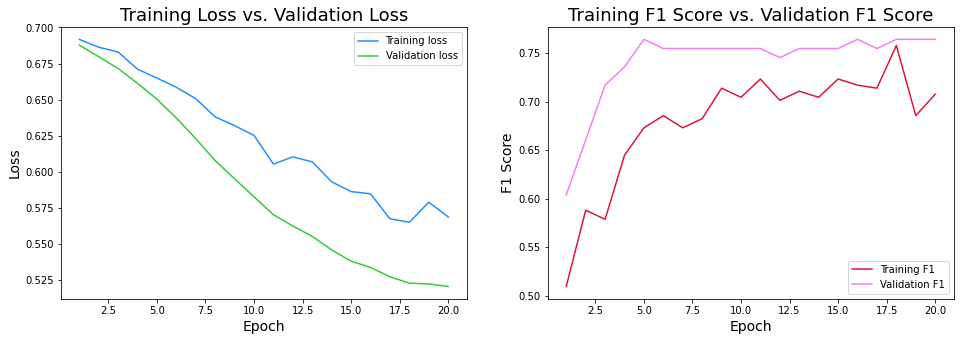

In [80]:
# Plot of validation and testing
loss = history.history['loss']
precision = np.array(history.history['precision'])   # array conversion for multiplication
recall = np.array(history.history['recall'])
f1 = list(2 * precision * recall / (precision + recall))  # back to list

val_loss = history.history['val_loss']
val_precision = np.array(history.history['val_precision'])
val_recall = np.array(history.history['val_recall'])
val_f1 = list(2 * val_precision * val_recall / (val_precision + val_recall))

epoch = range(1, len(loss) + 1)    # 1 ~ 20

# Training loss
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch, loss, 'dodgerblue', label='Training loss')
plt.title('Training Loss vs. Validation Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Validation loss
plt.plot(epoch, val_loss, 'limegreen', label='Validation loss')
plt.legend()

# Training f1 score
plt.subplot(1, 2, 2)
plt.plot(epoch, f1, 'crimson', label='Training F1')
plt.title('Training F1 Score vs. Validation F1 Score', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)

# Validation f1 score
plt.plot(epoch, val_f1, 'violet', label='Validation F1')
plt.legend()

plt.show()